In [1]:
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output
torch.manual_seed(0)

In [2]:
d = 50
mvn = torch.distributions.MultivariateNormal(torch.tensor([[15.], [-15]]).repeat(1,d) , torch.eye(d).unsqueeze(0).repeat(2,1,1))
weights = torch.distributions.Categorical(torch.tensor([.5,.5]))
distribution = torch.distributions.MixtureSameFamily(weights,mvn)

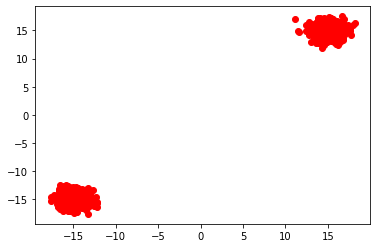

In [3]:
target_samples = distribution.sample([1000])
plt.scatter(target_samples[:,0].numpy(),target_samples[:,1].numpy(), color = 'red')

In [ ]:
import torch
from torch import nn
from torch.distributions import Categorical
from tqdm import tqdm

from models_dif.multivariate_normal_reference import MultivariateNormalReference
from models_dif.location_scale_flow import LocationScaleFlow
from models_dif.softmax_weight import SoftmaxWeight

class DIFSampler(nn.Module):
    def __init__(self, target_log_density, p, K):
        super().__init__()
        self.target_log_density = target_log_density
        self.p = p
        self.K = K

        self.w = SoftmaxWeight(self.K, self.p, [])

        self.T = LocationScaleFlow(self.K, self.p)

        self.reference = MultivariateNormalReference(self.p)

        self.loss_values = []
        self.para_list = list(self.parameters())
        self.optimizer = torch.optim.Adam(self.para_list, lr=5e-2)

    def compute_log_v(self, x):
        z = self.T.forward(x)
        log_v = self.reference.log_density(z) + torch.diagonal(self.w.log_prob(z), 0, -2, -1) + self.T.log_det_J(x)
        return log_v - torch.logsumexp(log_v, dim=-1, keepdim=True)

    def DKL_observed(self, z):
        x = self.T.backward(z)
        return torch.mean(torch.sum(torch.exp(self.w.log_prob(z))*(self.model_log_density(x) - self.target_log_density(x)),dim = -1))

    def DKL_latent(self,z):
        return torch.mean(self.reference.log_density(z) - self.proxy_log_density(z))

    def sample_model(self, num_samples):
        with torch.no_grad():
            z = self.reference.sample(num_samples)
            x = self.T.backward(z)
            pick = Categorical(torch.exp(self.w.log_prob(z))).sample()
            return torch.stack([x[i, pick[i], :] for i in range(num_samples)])

    def proxy_log_density(self, z):
        x = self.T.backward(z)
        return torch.logsumexp(torch.diagonal(self.compute_log_v(x), 0, -2, -1) + self.target_log_density(x) - self.T.log_det_J(x), dim=-1)

    def model_log_density(self, x):
        z = self.T.forward(x)
        return torch.logsumexp(torch.diagonal(self.w.log_prob(z), 0, -2, -1) + self.reference.log_density(z) + self.T.log_det_J(x),
            dim=-1)

    def train(self, epochs,num_samples, batch_size=None):
        if batch_size is None:
            batch_size = num_samples
        
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(device)
        
        reference_samples = self.reference.sample(num_samples).to(device)
        dataset = torch.utils.data.TensorDataset(reference_samples)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

        pbar = tqdm(range(epochs))
        for t in pbar:
            for i, batch in enumerate(dataloader):
                self.optimizer.zero_grad()
                batch_loss = self.DKL_observed(batch[0])
                batch_loss.backward()
                self.optimizer.step()
            with torch.no_grad():
                DKL_observed_values = self.DKL_observed(reference_samples).item()
            pbar.set_postfix_str('DKL observed = ' + str(round(DKL_observed_values, 6)) + ' ; device: ' + 'cuda' if torch.cuda.is_available() else 'DKL observed = ' + str(round(DKL_observed_values, 6)) + ' ; device: ' + 'cpu')
        self.to(torch.device('cpu'))
        

In [ ]:
#Try model
dif = DIFSampler(lambda samples: distribution.log_prob(samples.cpu()).to(samples.device),d,5)
dif.train(100,5000,500)
samples = dif.sample_model(10000)
print(samples.shape)
plt.figure(figsize = (6,6))
plt.scatter(samples[:,0].detach().numpy(), samples[:,1].detach().numpy(), color ='blue', alpha = .9)
plt.show()

In [67]:
class RealNVPLayer(nn.Module):
    def __init__(self,p,hidden_dim):
        super().__init__()
        self.p = p
        net_mean = []
        hs = [self.p] + hidden_dim + [self.p]
        for h0, h1 in zip(hs, hs[1:]):
            net_mean.extend([
                nn.Linear(h0, h1),
                nn.LeakyReLU(),
            ])
        net_mean.pop()
        self.net_mean = nn.Sequential(*net_mean)
        self.net_mean[-1].weight = nn.Parameter(torch.zeros_like(self.net_mean[-1].weight))
        self.net_mean[-1].bias = nn.Parameter(torch.zeros_like(self.net_mean[-1].bias))
        
        net_log_scale = []
        hs = [self.p] + hidden_dim + [self.p]
        for h0, h1 in zip(hs, hs[1:]):
            net_log_scale.extend([
                nn.Linear(h0, h1),
                nn.LeakyReLU(),
            ])
        net_log_scale.pop()
        self.net_log_scale = nn.Sequential(*net_log_scale)
        self.net_log_scale[-1].weight = nn.Parameter(.1*torch.ones_like(self.net_log_scale[-1].weight))
        self.net_log_scale[-1].bias = nn.Parameter(torch.zeros_like(self.net_log_scale[-1].bias))

        self.mask = [torch.cat([torch.zeros(int(self.p/2)), torch.ones(self.p - int(self.p/2))], dim = 0),torch.cat([torch.ones(int(self.p/2)), torch.zeros(self.p - int(self.p/2))], dim = 0)]
        self.lr = 5e-3
    
    def sample_forward(self,x):
        z = x
        for mask in reversed(self.mask):
            m, log_s = self.net_mean(mask * z)*(1 - mask),self.net_log_scale(mask * z)*(1 - mask)
            z = (z*(1 - mask) * torch.exp(log_s)+m) + z*mask
        return z

    def sample_backward(self, z):
        x = z
        for mask in self.mask:
            m, log_s = self.net_mean(mask * x)*(1 - mask),self.net_log_scale(mask * x)*(1 - mask)
            x = (x*(1-mask) -m)/torch.exp(log_s) + x*mask
        return x

    def log_det(self, x):
        z = x
        log_det = torch.zeros(x.shape[:-1])
        for mask in reversed(self.mask):
            m, log_s = self.net_mean(mask * z)*(1 - mask),self.net_log_scale(mask * z)*(1 - mask)
            z = (z*(1 - mask) * torch.exp(log_s)+m) + z*mask
            log_det += torch.sum(log_s, dim = -1)
        return log_det

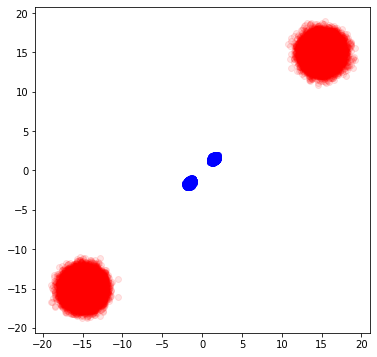

In [68]:
#Initialize f_\phi
from torch import nn
hidden_dimensions =[64,64,64]
real_nvp = RealNVPLayer(d, hidden_dimensions)
x = distribution.sample([100000])
  
clear_output(wait = True)
network_samples = real_nvp.sample_backward(x)
plt.figure(figsize = (6,6))
plt.scatter(network_samples[:,0].detach().numpy(), network_samples[:,1].detach().numpy(), color ='blue', alpha = .9)
plt.scatter(x[:,0].detach().numpy(), x[:,1].detach().numpy(), color = 'red', alpha = .1)
plt.show()

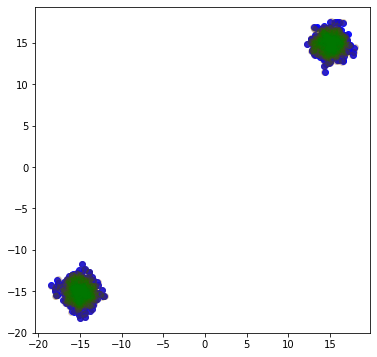

In [72]:
#Showing how f_phi becomes the identity function by minimzing MSE
def MSE(f, x):
    return torch.mean(torch.square(x - f(x)))

optimizer_f_phi = torch.optim.Adam(real_nvp.parameters(), lr = 5e-4)
x = distribution.sample([1000])
for t in range(100):
    optimizer_f_phi.zero_grad()
    batch_loss = MSE(real_nvp.sample_backward,x)
    batch_loss.backward()
    optimizer_f_phi.step()
    clear_output(wait = True)
    network_samples = real_nvp.sample_backward(x)
    new_x = real_nvp.sample_forward(network_samples)
    plt.figure(figsize = (6,6))
    plt.scatter(network_samples[:,0].detach().numpy(), network_samples[:,1].detach().numpy(), color ='blue', alpha = .9)
    plt.scatter(x[:,0].detach().numpy(), x[:,1].detach().numpy(), color = 'red', alpha = .1)
    plt.scatter(new_x[:,0].detach().numpy(), new_x[:,1].detach().numpy(), color = 'green', alpha = .1)
    plt.show()

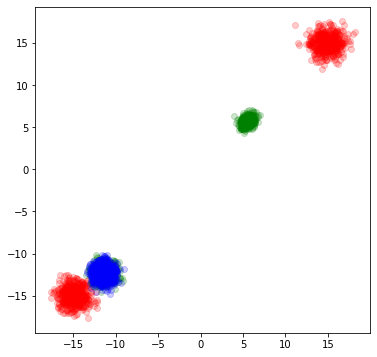

 46%|███████████████████████████████████████████████████████████████████████▊                                                                                    | 46/100 [02:14<04:32,  5.04s/it, DKL observed = 1.683663 ; device: cuda]

In [ ]:
#Initialize f_\phi
from torch import nn
hidden_dimensions =[64,64,64]
real_nvp = RealNVPLayer(d, hidden_dimensions)

#run algorithm
optimizer_f_phi = torch.optim.Adam(real_nvp.parameters(), lr = 5e-4)
target_log_density = lambda samples: distribution.log_prob(real_nvp.sample_forward(samples.cpu())).to(samples.device) + real_nvp.log_det(samples.cpu()).to(samples.device)
dif = DIFSampler(target_log_density, d, 10)
for macro_epochs in range(200):
    #train model on current target
    dif.train(100,10000,500)
    samples = dif.sample_model(1000)
    clear_output(wait = True)
    plt.figure(figsize = (6,6))
    plt.scatter(target_samples[:,0].detach().numpy(), target_samples[:,1].detach().numpy(), color ='red', alpha = .2)
    network_samples = real_nvp.sample_backward(target_samples)
    plt.scatter(network_samples[:,0].detach().numpy(), network_samples[:,1].detach().numpy(), color ='green', alpha = .2)
    plt.scatter(samples[:,0].detach().numpy(), samples[:,1].detach().numpy(), color ='blue', alpha = .2)
    plt.show()
    #update target by gradient step on MSE
    for t in range(1):
        optimizer_f_phi.zero_grad()
        batch_loss = MSE(real_nvp.sample_backward,samples)
        batch_loss.backward()
        optimizer_f_phi.step()